In [5]:
import os
import warnings
import logging

# Ignorar warnings generales de Python
warnings.filterwarnings('ignore')

# Suprimir logs de TensorFlow (solo errores)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = todos, 1 = info, 2 = warnings, 3 = error

# Desactivar logging de absl
logging.getLogger('absl').setLevel(logging.ERROR)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Verificar uso de GPU
print("Dispositivos disponibles:", tf.config.list_physical_devices('GPU'))



Dispositivos disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import shutil

base_path = 'dogs-vs-cats/train'
cat_path = os.path.join(base_path, 'cat')
dog_path = os.path.join(base_path, 'dog')

# Crear carpetas si no existen
os.makedirs(cat_path, exist_ok=True)
os.makedirs(dog_path, exist_ok=True)

# Mover archivos
for file in os.listdir(base_path):
    file_path = os.path.join(base_path, file)
    if os.path.isfile(file_path):
        if file.startswith('cat'):
            shutil.move(file_path, os.path.join(cat_path, file))
        elif file.startswith('dog'):
            shutil.move(file_path, os.path.join(dog_path, file))

print("Imágenes organizadas correctamente.")


Imágenes organizadas correctamente.


In [3]:
IMG_SIZE = 150
BATCH_SIZE = 32

train_dir = 'dogs-vs-cats/train'

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Congelar capas convolucionales
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas densas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
checkpoint = ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/100


I0000 00:00:1744222028.071655  101112 service.cc:146] XLA service 0x78603801ea00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744222028.071673  101112 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-09 20:07:08.097977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-09 20:07:08.236126: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90100
2025-04-09 20:07:08.823552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1511', 36 bytes spill stores, 40 bytes spill loads

2025-04-09 20:07:08.853389: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memo

  3/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.4497 - loss: 8.0321 

I0000 00:00:1744222037.155892  101112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8719 - loss: 1.1116

2025-04-09 20:07:59.475349: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.96600, saving model to vgg16_best_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 72ms/step - accuracy: 0.8720 - loss: 1.1107 - val_accuracy: 0.9660 - val_loss: 0.2203
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9633 - loss: 0.2175
Epoch 2: val_accuracy improved from 0.96600 to 0.97040, saving model to vgg16_best_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9633 - loss: 0.2176 - val_accuracy: 0.9704 - val_loss: 0.1910
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9671 - loss: 0.1630
Epoch 3: val_accuracy did not improve from 0.97040
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9671 - loss: 0.1630 - val_accuracy: 0.9694 - val_loss: 0.1811
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9716 - loss: 0.1194
Epoch 4: val_accuracy did not improve from 0.97040
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.9715 - loss: 0.1194 - val_accuracy: 0.

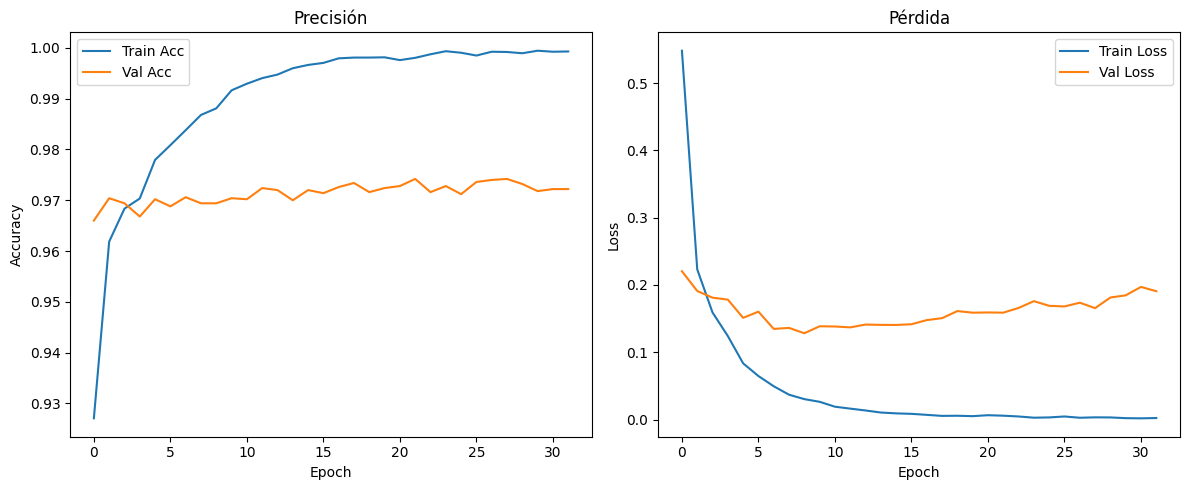

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Precisión')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
model.save('vgg16_final_model_dogs_vs_cats.keras')
print("Modelo guardado como vgg16_final_model_dogs_vs_cats.keras")

Modelo guardado como vgg16_final_model_dogs_vs_cats.keras


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step
Accuracy (umbral 0.5): 0.9742
Precision (umbral 0.5): 0.9717
Recall (umbral 0.5): 0.9768
F1-score (umbral 0.5): 0.9743

 Mejor umbral F1-score: 0.8239
Mejor umbral Precisión: 1.0000


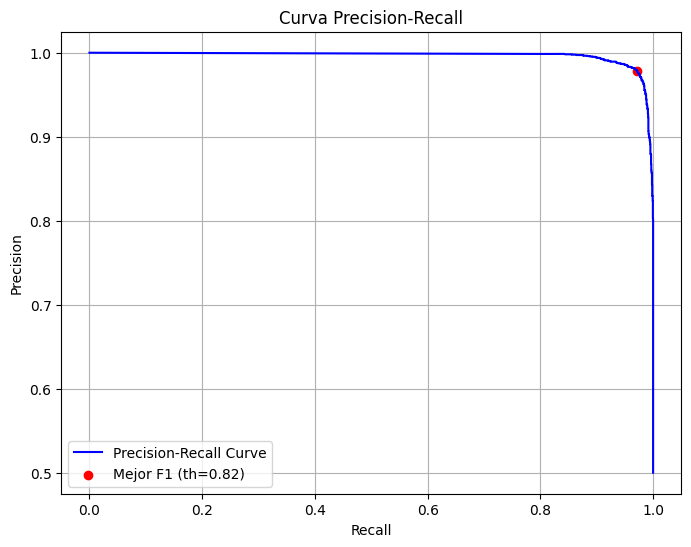

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Asegúrate de que val_gen esté definido
val_gen.reset()

# Cargar modelo
model = load_model('vgg16_final_model_dogs_vs_cats.keras')

# Obtener etiquetas verdaderas
y_true = val_gen.classes

# Obtener probabilidades de clase 1 ("dog")
y_probs = model.predict(val_gen, verbose=1)[:, 1]  # Probabilidades de clase positiva (dog)

# Umbral por defecto (0.5)
y_pred_default = (y_probs >= 0.5).astype(int)

# =====================
# MÉTRICAS CLÁSICAS CON UMBRAL 0.5
# =====================
acc = accuracy_score(y_true, y_pred_default)
prec = precision_score(y_true, y_pred_default)
rec = recall_score(y_true, y_pred_default)
f1 = f1_score(y_true, y_pred_default)

print(f"Accuracy (umbral 0.5): {acc:.4f}")
print(f"Precision (umbral 0.5): {prec:.4f}")
print(f"Recall (umbral 0.5): {rec:.4f}")
print(f"F1-score (umbral 0.5): {f1:.4f}")

# =====================
# CURVA PRECISION-RECALL
# =====================
precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)

# F1-score en todos los umbrales
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Umbrales óptimos
best_thresh_f1 = thresholds[np.argmax(f1s)]
best_thresh_prec = thresholds[np.argmax(precisions[:-1])]  # el último valor de thresholds está fuera de rango
best_thresh_rec = thresholds[np.argmax(recalls[:-1])]

print(f"\n Mejor umbral F1-score: {best_thresh_f1:.4f}")
print(f"Mejor umbral Precisión: {best_thresh_prec:.4f}")

# =====================
# GRAFICAR CURVA
# =====================
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, label='Precision-Recall Curve', color='blue')
plt.scatter(recalls[np.argmax(f1s)], precisions[np.argmax(f1s)], color='red', label=f'Mejor F1 (th={best_thresh_f1:.2f})')
plt.title('Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step
Etiquetas: ['cat', 'dog']

Reporte:
              precision    recall  f1-score   support

         cat       0.98      0.97      0.97      2500
         dog       0.97      0.98      0.97      2500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



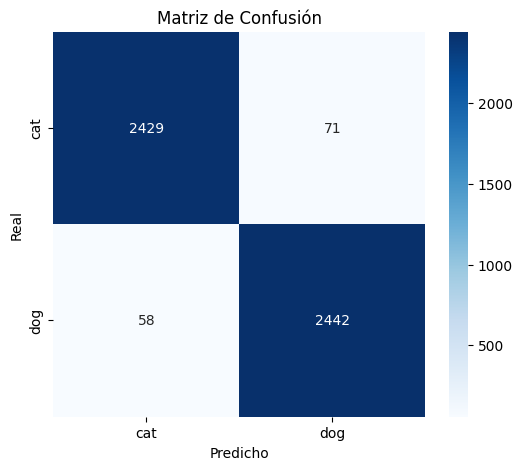

In [10]:
from tensorflow.keras.models import load_model

model = load_model('vgg16_best_model.h5')

# Predicción
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print("Etiquetas:", labels)

print("\nReporte:")
print(classification_report(y_true, y_pred, target_names=labels))

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step
Umbral usado (mejor F1-score): 0.8239

Etiquetas: ['cat', 'dog']

 Classification Report:
              precision    recall  f1-score   support

         cat       0.97      0.98      0.98      2500
         dog       0.98      0.97      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



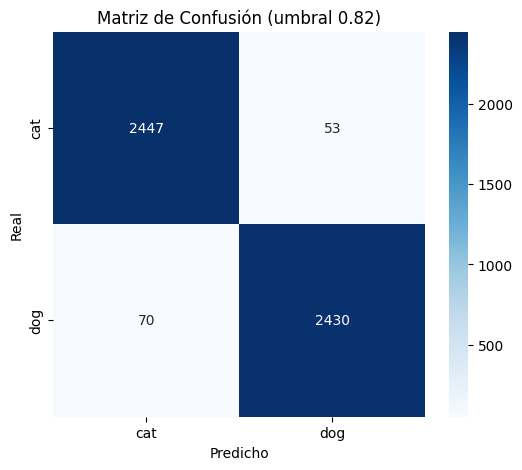

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ======= PARÁMETROS =======
MODEL_PATH = 'vgg16_best_model.h5'
USE_BEST_F1 = True     # ← Cambiar a False para fijar umbral manual
MANUAL_THRESHOLD = 0.5 # ← Solo se usa si USE_BEST_F1 = False

# ======= CARGAR MODELO Y DATOS =======
model = load_model(MODEL_PATH)
val_gen.reset()
y_probs = model.predict(val_gen, verbose=1)[:, 1]  # Probabilidad clase positiva (dog)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

# ======= DEFINIR UMBRAL =======
if USE_BEST_F1:
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_thresh = thresholds[np.argmax(f1s)]
    print(f"Umbral usado (mejor F1-score): {best_thresh:.4f}")
else:
    best_thresh = MANUAL_THRESHOLD
    print(f"Umbral usado (manual): {best_thresh:.4f}")

# ======= PREDICCIÓN FINAL =======
y_pred = (y_probs >= best_thresh).astype(int)

# ======= REPORTE =======
print("\nEtiquetas:", labels)
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# ======= MATRIZ DE CONFUSIÓN =======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (umbral {best_thresh:.2f})')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


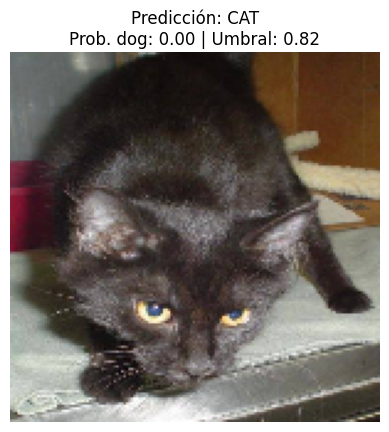

In [25]:
import os
import random
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# ========= CONFIGURACIÓN =========
IMG_SIZE = 150
TEST_DIR = 'dogs-vs-cats/test1/'
MODEL_PATH = 'vgg16_final_model_dogs_vs_cats.keras'
CLASSES = ['cat', 'dog']
UMBRAL = 0.82  # ← Puedes ajustar esto manualmente o usar el mejor F1-score obtenido

# ========= CARGA DE MODELO =========
model = load_model(MODEL_PATH)

# ========= SELECCIONAR IMAGEN ALEATORIA =========
random_img = random.choice(os.listdir(TEST_DIR))
img_path = os.path.join(TEST_DIR, random_img)

# ========= PREPROCESAR IMAGEN =========
img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = img_to_array(img)
img_array = preprocess_input(img_array)
img_batch = np.expand_dims(img_array, axis=0)

# ========= HACER PREDICCIÓN =========
pred = model.predict(img_batch)[0]
prob_dog = pred[1]  # Clase 1 = dog

# ========= CLASIFICAR SEGÚN UMBRAL =========
pred_label = 'dog' if prob_dog >= UMBRAL else 'cat'

# ========= VISUALIZAR RESULTADO =========
plt.imshow(img)
plt.title(f"Predicción: {pred_label.upper()}\nProb. dog: {prob_dog:.2f} | Umbral: {UMBRAL}")
plt.axis('off')
plt.show()



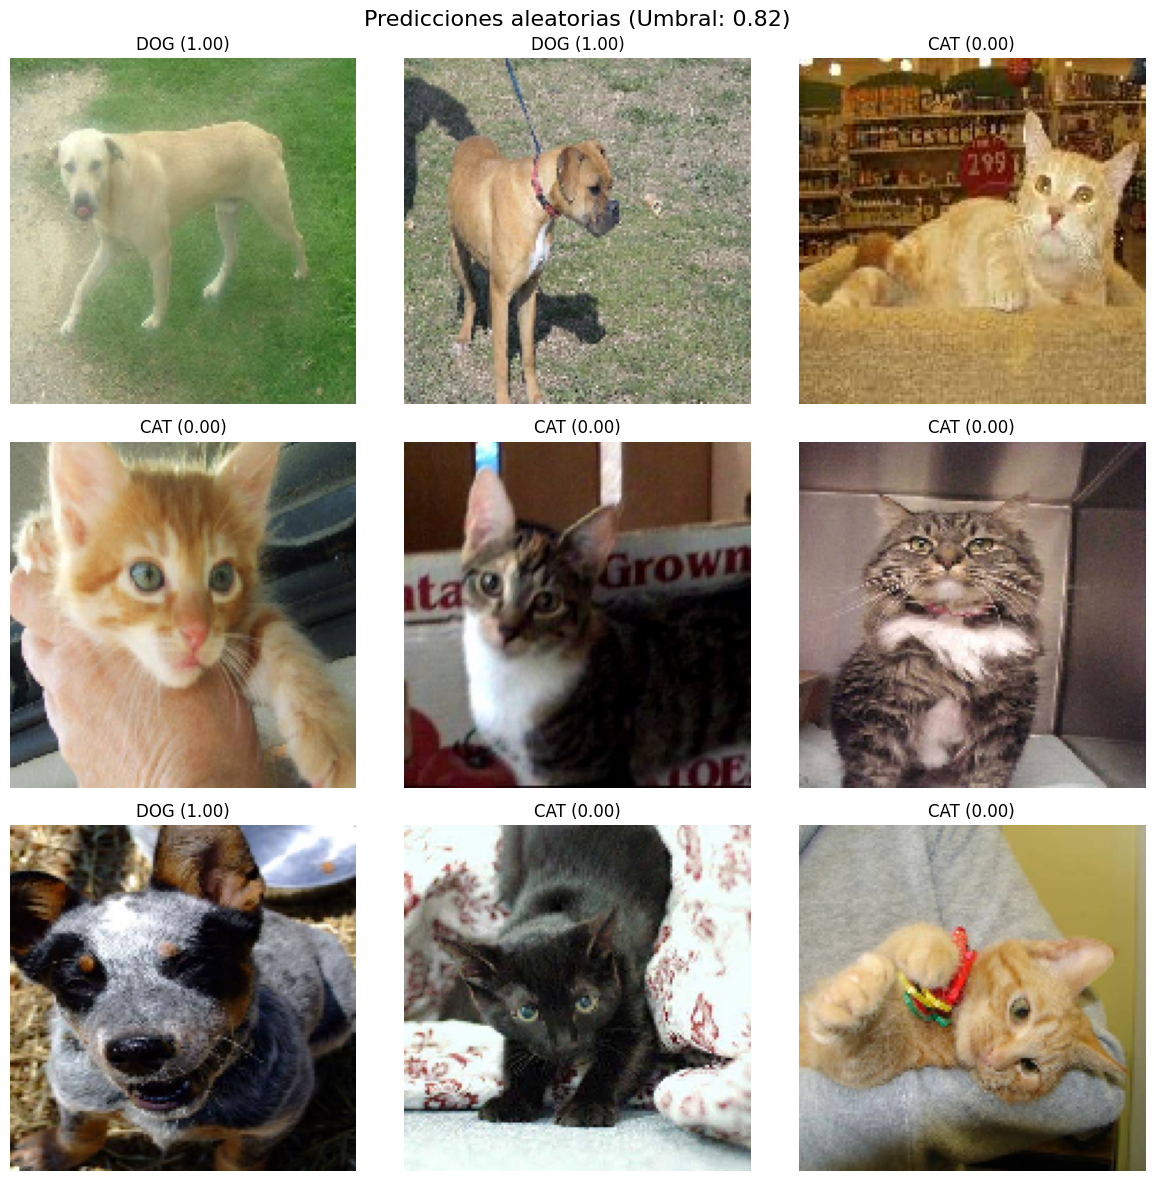

In [23]:
# ======= CONFIGURACIÓN =======

NUM_IMGS = 9  

# ======= CARGAR MODELO =======
model = load_model(MODEL_PATH)

# ======= SELECCIONAR IMÁGENES ALEATORIAS =======
img_files = random.sample(os.listdir(TEST_DIR), NUM_IMGS)

# ======= PREDICCIONES Y VISUALIZACIÓN =======
plt.figure(figsize=(12, 12))

for i, fname in enumerate(img_files):
    img_path = os.path.join(TEST_DIR, fname)
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_batch = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_batch, verbose=0)[0]
    prob_dog = pred[1]
    pred_label = 'dog' if prob_dog >= UMBRAL else 'cat'

    # Mostrar imagen
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"{pred_label.upper()} ({prob_dog:.2f})")
    plt.axis('off')

plt.suptitle(f"Predicciones aleatorias (Umbral: {UMBRAL})", fontsize=16)
plt.tight_layout()
plt.show()
